In [1]:
import sqlite3
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
conn = sqlite3.connect('../db/olist_ecommerce.db')

a - What is the volume of orders per month? Are sales seasonal?

In [3]:
query = """
SELECT 
    strftime('%Y-%m', order_purchase_timestamp) AS purchase_timestamp,
    COUNT(DISTINCT order_id) AS total_orders
FROM df_olist_orders_dataset
WHERE order_status IN ('approved', 'processing', 'shipped', 'invoiced', 'delivered')
  AND order_purchase_timestamp != '1900-01-01 00:00:00'
GROUP BY purchase_timestamp
ORDER BY purchase_timestamp
"""

df_monthly = pd.read_sql_query(query, conn)

In [4]:
fig = px.line(
    df_monthly,
    x='purchase_timestamp',
    y='total_orders',
    title='Order Volume per Month',
    labels={'purchase_timestamp': 'Year-Month', 'total_orders': 'Number of Orders'}
)
fig.update_xaxes(type='category', tickangle=45)
fig.update_layout(hovermode='x unified')
fig.show()

<Figure size 1200x800 with 0 Axes>

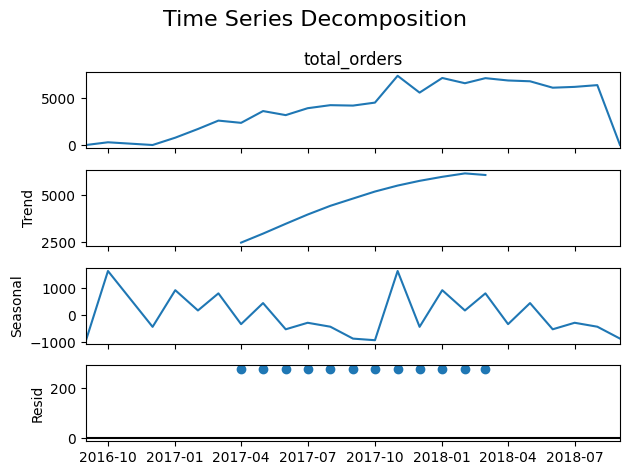

In [6]:

df_monthly['purchase_timestamp'] = pd.to_datetime(df_monthly['purchase_timestamp'])



df_monthly_indexed = df_monthly.set_index('purchase_timestamp')


decomposition = seasonal_decompose(df_monthly_indexed['total_orders'], model='additive', period=12)


plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle('Time Series Decomposition', fontsize=16)
plt.tight_layout()
plt.show()

The monthly order values can be seen in the timeline graph in the highlighted periods, showing growth over the period analysed.

After removing the seasonality effect from the time series, it is possible to identify this impact in periods such as October 2016 and November 2017, possibly associated with Black Friday.

b - What is the distribution of order delivery times?

In [22]:
query = """
SELECT 
    order_id,
    order_purchase_timestamp,
    order_approved_at,
    order_delivered_customer_date
FROM df_olist_orders_dataset
WHERE order_status = 'delivered' 
  AND delivered_status = 'delivered'
"""

df_frequency_delivered_time = pd.read_sql_query(query, conn)

In [23]:
df_frequency_delivered_time['order_purchase_timestamp'] = pd.to_datetime(df_frequency_delivered_time['order_purchase_timestamp'])
df_frequency_delivered_time['order_delivered_customer_date'] = pd.to_datetime(df_frequency_delivered_time['order_delivered_customer_date'])

In [24]:
df_frequency_delivered_time['delivered_vs_purchased'] = (df_frequency_delivered_time['order_delivered_customer_date'] - df_frequency_delivered_time['order_purchase_timestamp']).dt.days

df_frequency_delivered_time = df_frequency_delivered_time[
    (df_frequency_delivered_time['delivered_vs_purchased'] >= 0)
]

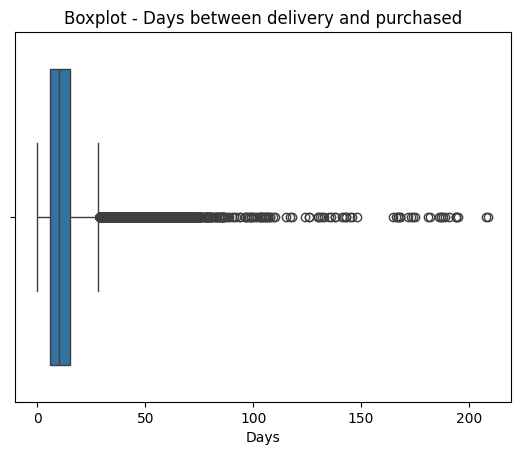

Outliers: 5022 registers
Proportion: 5.21% do total (96470 registers)
Upper limit considered: 28.5 dias


In [66]:

sns.boxplot(x=df_frequency_delivered_time['delivered_vs_purchased'])
plt.title("Boxplot - Days between delivery and purchased")
plt.xlabel("Days")
plt.show()


q1 = df_frequency_delivered_time['delivered_vs_purchased'].quantile(0.25)
q3 = df_frequency_delivered_time['delivered_vs_purchased'].quantile(0.75)
iqr = q3 - q1


upper_bound = q3 + 1.5 * iqr


outliers = df_frequency_delivered_time[df_frequency_delivered_time['delivered_vs_purchased'] > upper_bound]


num_outliers = outliers.shape[0]


total = df_frequency_delivered_time.shape[0]
proporcao_outliers = num_outliers / total * 100

print(f"Outliers: {num_outliers} registers")
print(f"Proportion: {proporcao_outliers:.2f}% do total ({total} registers)")
print(f"Upper limit considered: {upper_bound:.1f} dias")

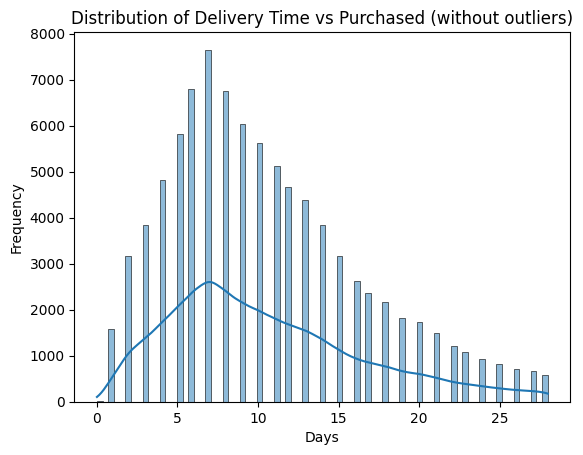

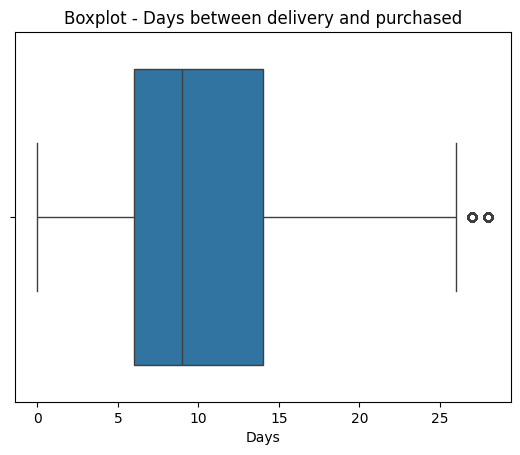

In [26]:
filtered_df = df_frequency_delivered_time[
    df_frequency_delivered_time['delivered_vs_purchased'] <= upper_bound  
]

sns.histplot(filtered_df['delivered_vs_purchased'], kde=True)
plt.title("Distribution of Delivery Time vs Purchased (without outliers)")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show()

sns.boxplot(x=filtered_df['delivered_vs_purchased'])
plt.title("Boxplot - Days between delivery and purchased")
plt.xlabel("Days")
plt.show()

In [27]:

def categorise_time(days):
    if 1 < days <= 7:
        return 'Between 1 and 7 days'
    elif 7 < days <= 14:
        return 'Between 7 and 14 days'
    elif 14 < days <= 21:
        return 'Between 14 and 21 days'
    elif 21 < days <= 29:
        return 'Between 21 and 29 days'
    else:
        return '0–1 day or >29 days'

filtered_df['delivered_vs_purchased'] = filtered_df['delivered_vs_purchased'].apply(categorise_time)


count = filtered_df['delivered_vs_purchased'].value_counts().sort_index()


proportion = (count / count.sum() * 100).round(2)


result = pd.DataFrame({
    'Quantity of Orders': count,
    'Proportion (%)': proportion
})

ordered_categories = [
    '0–1 day or >29 days',
    'Between 1 and 7 days',
    'Between 7 and 14 days',
    'Between 14 and 21 days',
    'Between 21 and 29 days'
]

result = result.reindex(ordered_categories)

print(result)

                        Quantity of Orders  Proportion (%)
delivered_vs_purchased                                    
0–1 day or >29 days                   1585            1.73
Between 1 and 7 days                 32111           35.11
Between 7 and 14 days                36397           39.80
Between 14 and 21 days               15369           16.81
Between 21 and 29 days                5986            6.55


C:\Users\lpraz\AppData\Local\Temp\ipykernel_21288\3185882735.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The distribution of order deliveries shows that most deliveries (close to 76%) take place between 1 and 14 days, 39.8%. Specifically, 39.8% between 7 and 14 days, and 35.11% between 1 and 7 days. Only 1.73% of orders are delivered in less than one day or more than 29 days, indicating that there is consistency in the delivery period.

c - What is the relationship between the cost of freight and the delivery distance?

In [28]:
query = """
WITH geo_avg AS (
    SELECT 
        geolocation_zip_code_prefix AS zip_prefix,
        AVG(geolocation_lat) AS lat,
        AVG(geolocation_lng) AS lng
    FROM df_geolocation_dataset
    GROUP BY geolocation_zip_code_prefix
),

customer_location AS (
    SELECT 
        o.order_id,
        o.customer_id,
        c.customer_state,                             
        g.lat AS lat_customer,
        g.lng AS lng_customer
    FROM df_olist_orders_dataset o
    JOIN df_customers_dataset c ON o.customer_id = c.customer_id
    LEFT JOIN geo_avg g ON c.customer_zip_code_prefix = g.zip_prefix
    WHERE o.order_status = 'delivered' AND order_delivered_customer_date <> '1900-01-01 00:00:00'
),

seller_location AS (
    SELECT 
        s.seller_id,
        s.seller_zip_code_prefix,
        s.seller_state,                              
        g.lat AS lat_seller,
        g.lng AS lng_seller
    FROM df_olist_sellers_dataset s
    LEFT JOIN geo_avg g ON s.seller_zip_code_prefix = g.zip_prefix
),

freight_base AS (
    SELECT 
        oi.order_id,
        cl.customer_id,
        cl.customer_state,                             
        oi.product_id,
        oi.seller_id,
        sl.seller_state,                               
        oi.freight_value,
        p.product_weight_g AS weight,
        (p.product_length_cm * p.product_height_cm * p.product_width_cm) AS volume,
        oi.price,
        oi.shipping_limit_date,
        cl.lat_customer,
        cl.lng_customer,
        sl.lat_seller,
        sl.lng_seller
    FROM df_order_items_com_datas oi
    LEFT JOIN df_olist_products_dataset p ON oi.product_id = p.product_id
    LEFT JOIN customer_location cl ON oi.order_id = cl.order_id
    LEFT JOIN seller_location sl ON oi.seller_id = sl.seller_id
)

SELECT *
FROM freight_base;
"""

df_freight = pd.read_sql_query(query, conn)

In [29]:
df_freight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   customer_id          110189 non-null  object 
 2   customer_state       110189 non-null  object 
 3   product_id           112650 non-null  object 
 4   seller_id            112650 non-null  object 
 5   seller_state         112650 non-null  object 
 6   freight_value        112650 non-null  float64
 7   weight               112632 non-null  float64
 8   volume               112632 non-null  float64
 9   price                112650 non-null  float64
 10  shipping_limit_date  112650 non-null  object 
 11  lat_customer         109901 non-null  float64
 12  lng_customer         109901 non-null  float64
 13  lat_seller           112397 non-null  float64
 14  lng_seller           112397 non-null  float64
dtypes: float64(8), ob

In [30]:
df_freight.isnull().sum()

order_id                  0
customer_id            2461
customer_state         2461
product_id                0
seller_id                 0
seller_state              0
freight_value             0
weight                   18
volume                   18
price                     0
shipping_limit_date       0
lat_customer           2749
lng_customer           2749
lat_seller              253
lng_seller              253
dtype: int64

In [31]:

df_freight['weight'] = df_freight['weight'].fillna(df_freight['weight'].median())
df_freight['volume'] = df_freight['volume'].fillna(df_freight['volume'].median())


df_freight = df_freight.dropna(subset=['lat_customer', 'lng_customer', 'lat_seller', 'lng_seller'])

In [32]:
df_freight.isnull().sum()

order_id               0
customer_id            0
customer_state         0
product_id             0
seller_id              0
seller_state           0
freight_value          0
weight                 0
volume                 0
price                  0
shipping_limit_date    0
lat_customer           0
lng_customer           0
lat_seller             0
lng_seller             0
dtype: int64

In [34]:
df_freight['weight_kg'] = df_freight['weight'] / 1000
df_freight['volume_m3'] = df_freight['volume'] / 1000000

In [36]:
def haversine(lat1, lon1, lat2, lon2):
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))

    
    km = 6371 * c
    return km


df_freight['distance_km'] = haversine(
    df_freight['lat_customer'], df_freight['lng_customer'],
    df_freight['lat_seller'], df_freight['lng_seller']
)

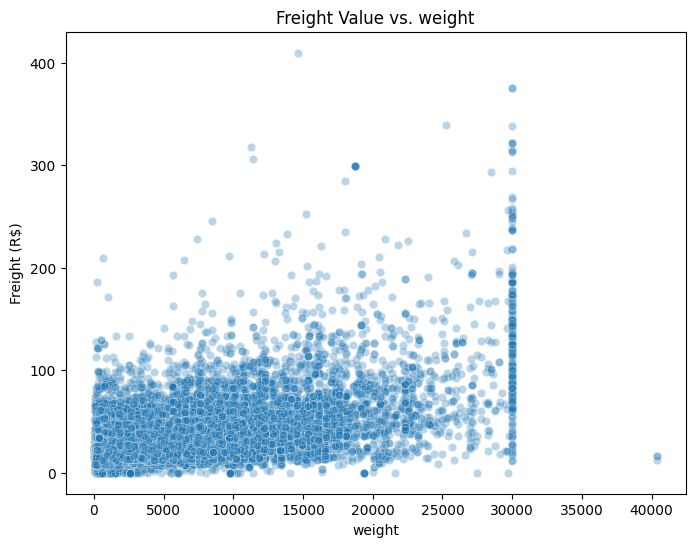

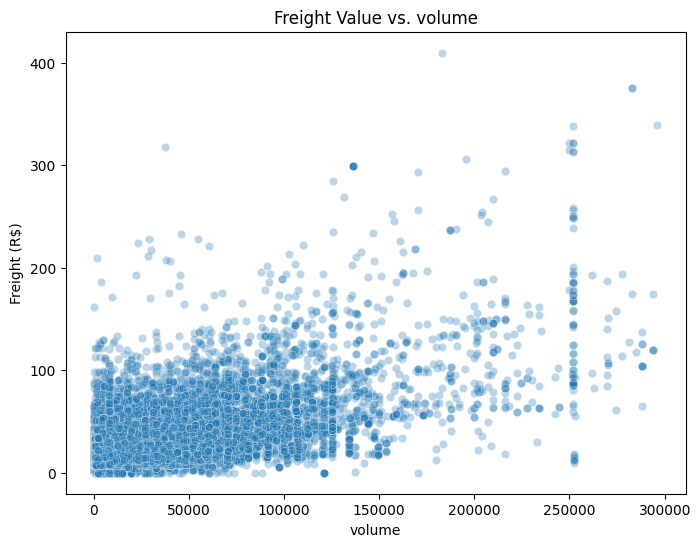

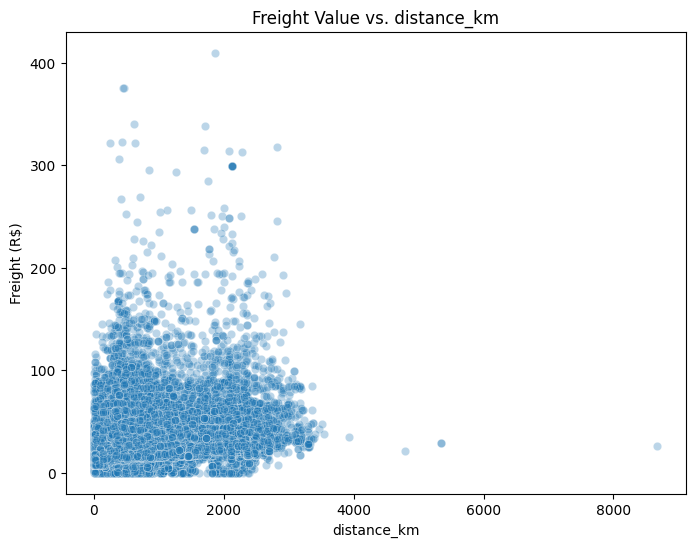

In [43]:
cols = ['weight', 'volume', 'distance_km']
for col in cols:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_freight[col], y='freight_value', data=df_freight, alpha=0.3)
    plt.title(f'Freight Value vs. {col}')
    plt.xlabel(col)
    plt.ylabel('Freight (R$)')
    plt.show()

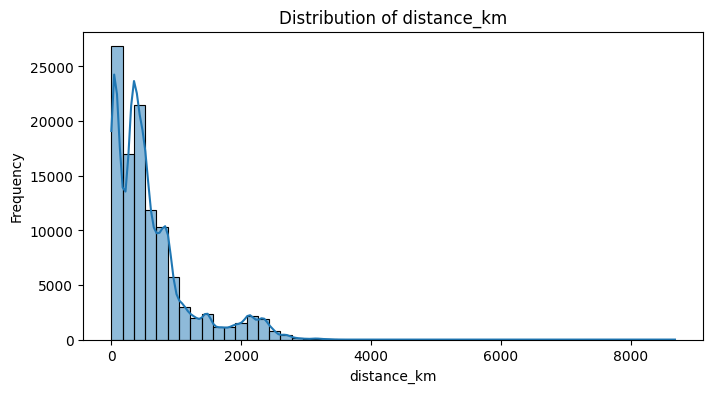

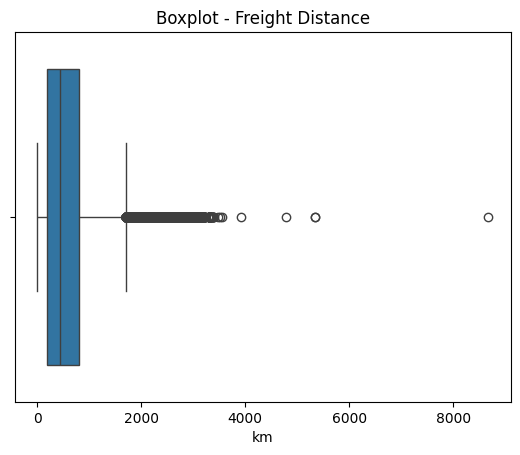

Outliers: 8390 registros
Proportion: 7.65% do total (109653 registros)
Upper limit considered: 1701.2 dias


In [44]:
plt.figure(figsize=(8, 4))
sns.histplot(df_freight['distance_km'], bins=50, kde=True)
plt.title(f'Distribution of {col}')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.show()


sns.boxplot(x=df_freight['distance_km'])
plt.title("Boxplot - Freight Distance")
plt.xlabel("km")
plt.show()


q1 = df_freight['distance_km'].quantile(0.25)
q3 = df_freight['distance_km'].quantile(0.75)
iqr = q3 - q1


upper_bound = q3 + 1.5 * iqr


outliers = df_freight[df_freight['distance_km'] > upper_bound]


num_outliers = outliers.shape[0]


total = df_freight.shape[0]
proporcao_outliers = num_outliers / total * 100

print(f"Outliers: {num_outliers} registros")
print(f"Proportion: {proporcao_outliers:.2f}% do total ({total} registros)")
print(f"Upper limit considered: {upper_bound:.1f} dias")



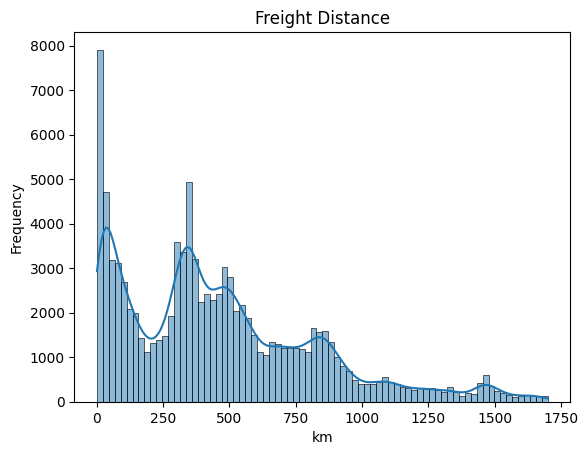

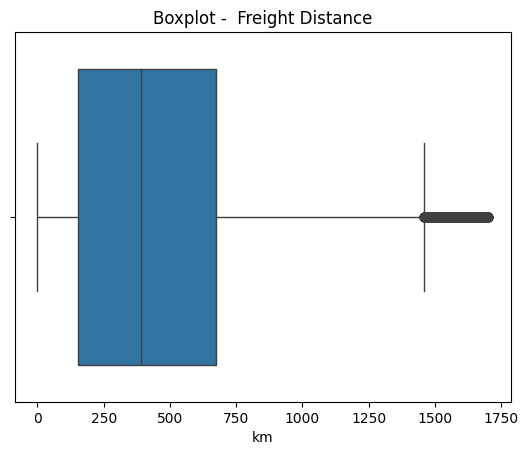

In [45]:
filtered_df_distance = df_freight[
    df_freight['distance_km'] <= upper_bound  
]

sns.histplot(filtered_df_distance['distance_km'], kde=True)
plt.title("Freight Distance")
plt.xlabel("km")
plt.ylabel("Frequency")
plt.show()

sns.boxplot(x=filtered_df_distance['distance_km'])
plt.title("Boxplot -  Freight Distance")
plt.xlabel("km")
plt.show()

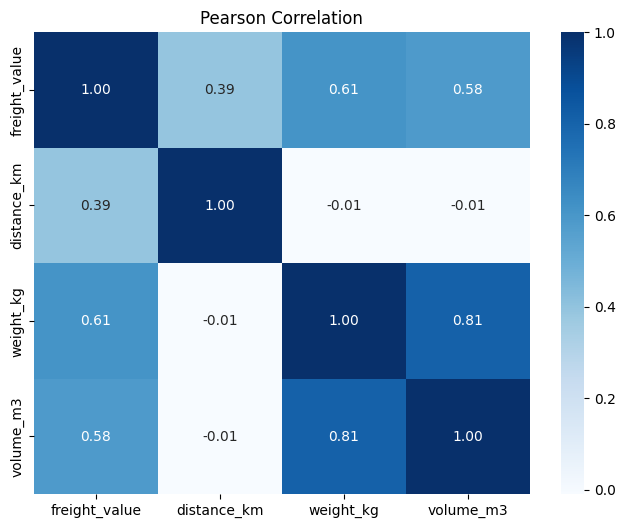

In [46]:

cols = ['freight_value', 'distance_km', 'weight_kg', 'volume_m3']


correlation_matrix = df_freight[cols].corr(method='pearson')


plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Pearson Correlation")
plt.show()

In [47]:
X = df_freight[['distance_km', 'weight_kg', 'volume_m3']]
y = df_freight['freight_value']


X = sm.add_constant(X)


model = sm.OLS(y, X).fit()


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          freight_value   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                 4.558e+04
Date:                Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                        13:36:02   Log-Likelihood:            -4.1322e+05
No. Observations:              109653   AIC:                         8.265e+05
Df Residuals:                  109649   BIC:                         8.265e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.3916      0.050    148.633      

In [48]:

X_vif = df_freight[['distance_km', 'weight_kg', 'volume_m3']]

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)

       feature       VIF
0  distance_km  1.173361
1    weight_kg  3.769221
2    volume_m3  3.898534


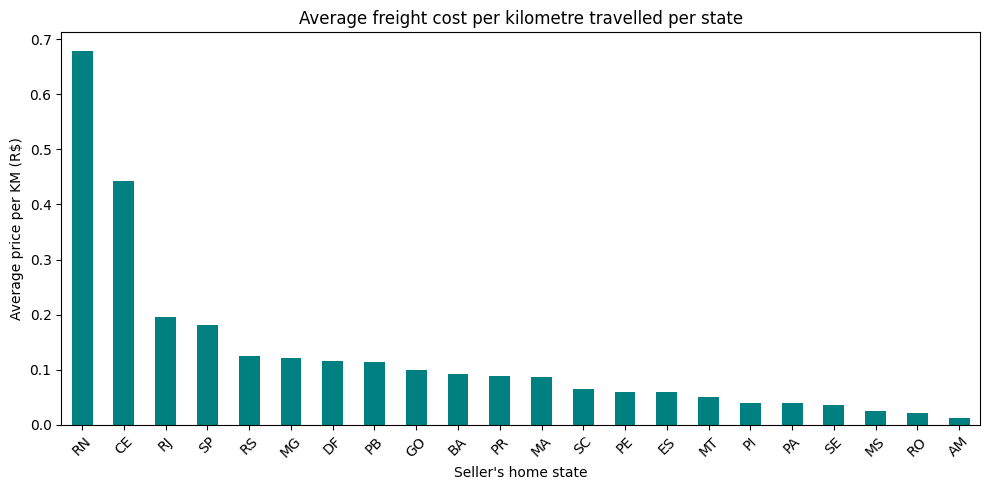

In [49]:

df_freight["freight_per_km"] = df_freight["freight_value"] / df_freight["distance_km"]


df_freight = df_freight[df_freight["distance_km"] > 0]


freight_per_state = df_freight.groupby("seller_state")["freight_per_km"].mean().sort_values(ascending=False)

freight_per_state.plot(kind="bar", figsize=(10, 5), color='teal')
plt.title("Average freight cost per kilometre travelled per state")
plt.ylabel("Average price per KM (R$)")
plt.xlabel("Seller's home state")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [50]:
df_freight.to_sql("df_freight", conn, if_exists="replace", index=False)


109627

Pearson's correlation shows that weight and volume are more strongly related to the value of freight than distance. When we consider the multiple linear regression, we see that all the variables are statistically significant.
The distance coefficient indicates that for each additional kilometre, the value of freight increases by an average of R$0.01, while 1 kg more raises freight by R$1.69, and 1 additional m³ has an impact of R$177. So, although distance has a positive effect on the value of freight, volume and weight are factors with a greater impact, with volume being the most significant.

Even so, as the question refers specifically to the relationship between distance and freight, we present statistical evidence that there is a positive and significant relationship between the two, albeit less intense than the others.


d - What are the best-selling product categories in terms of revenue?

In [52]:
query = """
SELECT 
    oi.order_id,
    oi.product_id,
    p.product_category_name,
    oi.price
FROM df_order_items_com_datas oi
JOIN df_olist_orders_dataset o ON oi.order_id = o.order_id
LEFT JOIN df_olist_products_dataset p ON oi.product_id = p.product_id
WHERE o.order_status IN ('approved', 'processing', 'invoiced', 'shipped', 'delivered');
"""

df_category_best_sellers = pd.read_sql_query(query, conn)

In [53]:
df_category_best_sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112101 entries, 0 to 112100
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               112101 non-null  object 
 1   product_id             112101 non-null  object 
 2   product_category_name  112083 non-null  object 
 3   price                  112101 non-null  float64
dtypes: float64(1), object(3)
memory usage: 3.4+ MB


In [54]:
df_category_best_sellers['product_category_name'] = df_category_best_sellers['product_category_name'].fillna('not categorized')

In [55]:
df_category_best_sellers.nunique()

order_id                 98199
product_id               32729
product_category_name       74
price                     5934
dtype: int64

In [56]:

total = len(df_category_best_sellers)


not_cat_count = df_category_best_sellers[df_category_best_sellers['product_category_name'] == 'not categorized'].shape[0]


not_cat_pct = (not_cat_count / total) * 100

print(f"Total of 'not categorized': {not_cat_count}")
print(f"Percentage: {not_cat_pct:.2f}%")

Total of 'not categorized': 1590
Percentage: 1.42%


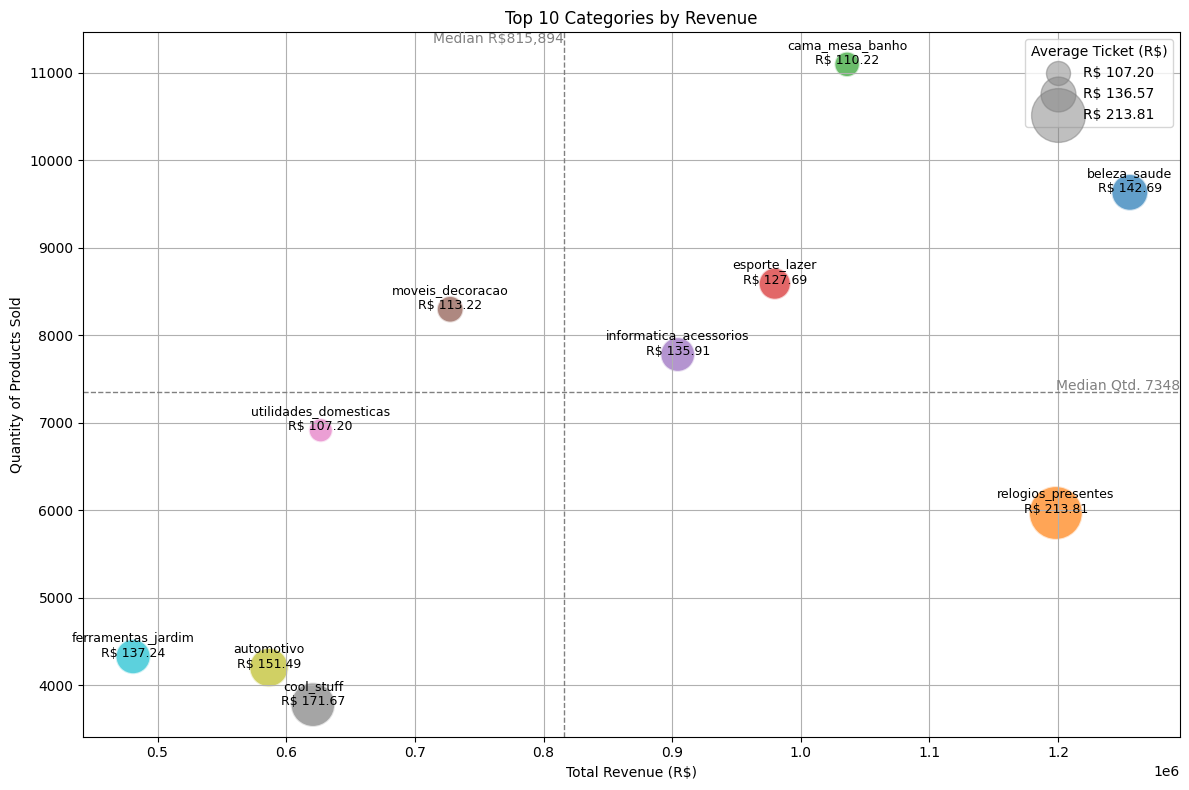

In [57]:

df_summary = df_category_best_sellers.groupby('product_category_name').agg(
    total_revenue=('price', 'sum'),
    total_orders=('order_id', 'nunique'),
    total_items=('product_id', 'count')
).reset_index()

df_summary['avg_ticket'] = df_summary['total_revenue'] / df_summary['total_orders']


top10 = df_summary.sort_values(by='total_revenue', ascending=False).head(10)


median_revenue = top10['total_revenue'].median()
median_items = top10['total_items'].median()


plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=top10,
    x='total_revenue',
    y='total_items',
    size='avg_ticket',
    hue='product_category_name',
    sizes=(300, 1500),
    alpha=0.7,
    legend=False
)


for i in range(top10.shape[0]):
    plt.text(
        top10['total_revenue'].iloc[i],
        top10['total_items'].iloc[i],
        f"{top10['product_category_name'].iloc[i]}\nR$ {top10['avg_ticket'].iloc[i]:.2f}",
        fontsize=9,
        ha='center'
    )


plt.axvline(median_revenue, color='gray', linestyle='--', linewidth=1)
plt.axhline(median_items, color='gray', linestyle='--', linewidth=1)
plt.text(median_revenue, plt.ylim()[1], f'Median R${median_revenue:,.0f}', color='gray', va='top', ha='right')
plt.text(plt.xlim()[1], median_items, f'Median Qtd. {median_items:.0f}', color='gray', va='bottom', ha='right')


for s in [top10['avg_ticket'].min(), top10['avg_ticket'].median(), top10['avg_ticket'].max()]:
    plt.scatter([], [], s=300 + (s - top10['avg_ticket'].min()) /
                (top10['avg_ticket'].max() - top10['avg_ticket'].min() + 1e-6) * (1500 - 300),
                label=f"R$ {s:.2f}", alpha=0.5, color='gray')

plt.legend(title='Average Ticket (R$)', loc='upper right', frameon=True)


plt.title('Top 10 Categories by Revenue')
plt.xlabel('Total Revenue (R$)')
plt.ylabel('Quantity of Products Sold')
plt.grid(True)
plt.tight_layout()
plt.show()

d - What are the best-selling product categories in terms of turnover?

Analysing the Quadrants Based on the Scatter Graph

Based on the scatter graph constructed, four quadrants were defined based on the medians of two indicators: total turnover (X axis) and quantity of items sold (Y axis). The size of the bubbles represents the average ticket for each category. This segmentation allows for strategic decision-making analyses of the main product categories. Below are the insights by quadrant:

Q1 - Low turnover, low sales:
This is the least favourable quadrant. The initial focus should be on marketing and visibility actions to increase the number of sales. Subsequently, it is possible to think about strategies to increase the average ticket and, consequently, turnover.

Q2 - Low turnover, high sales:
In this quadrant, the categories have a good volume of sales but generate little turnover, which indicates a low average ticket. In this case, it is recommended to review the pricing strategy. Some possible actions include renegotiating with suppliers, developing new commercial partners, or even restructuring the price list. The aim is to improve the average ticket without negatively impacting sales volume.

Q3 - High turnover, low sales:
This quadrant represents categories with excellent turnover performance even with few sales, usually due to a high average ticket. These categories are highly valuable to the business. Marketing strategies can be applied to further exploit this potential, broadening the reach and seeking out new audiences. In addition, it may be interesting to diversify the offer within these categories to expand sales opportunities.

Q4 - High turnover, high number of sales:
This is the ideal quadrant. The categories here combine high sales volume with high turnover. Despite the good performance, there is still room for improvement, especially through more targeted marketing campaigns that further boost sales or strengthen customer loyalty.


Once these strategies have been tested and validated, they can be replicated for other categories in the company's portfolio, contributing to sustained business growth.

e - Which Brazilian states have the highest average order value?


In [58]:
query = """
SELECT 
    f.order_id,
    f.customer_id,
    f.customer_state,
    p.payment_value
FROM  df_freight f
INNER JOIN df_olist_order_payments_dataset p ON f.order_id = p.order_id
INNER JOIN df_olist_orders_dataset o ON f.order_id = o.order_id
WHERE o.order_status IN ('approved', 'processing', 'invoiced', 'shipped', 'delivered');
"""

df_average_order_value = pd.read_sql_query(query, conn)

In [59]:
df_average_order_value.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114447 entries, 0 to 114446
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   order_id        114447 non-null  object 
 1   customer_id     114447 non-null  object 
 2   customer_state  114447 non-null  object 
 3   payment_value   114447 non-null  float64
dtypes: float64(1), object(3)
memory usage: 3.5+ MB


In [60]:
df_order_payment = df_average_order_value.groupby(['order_id', 'customer_state']).agg({
    'payment_value': 'sum'
}).reset_index()

In [62]:
df_state_metrics = df_order_payment.groupby('customer_state').agg({
    'payment_value': ['sum', 'mean', 'count']
}).reset_index()

df_state_metrics.columns = ['state', 'total_revenue', 'avg_ticket', 'qtt_orders']

total_revenue = df_state_metrics['total_revenue'].sum()
df_state_metrics['percent_revenue'] = (df_state_metrics['total_revenue'] / total_revenue) * 100


df_state_metrics = df_state_metrics.sort_values(by='total_revenue', ascending=False).reset_index(drop=True)


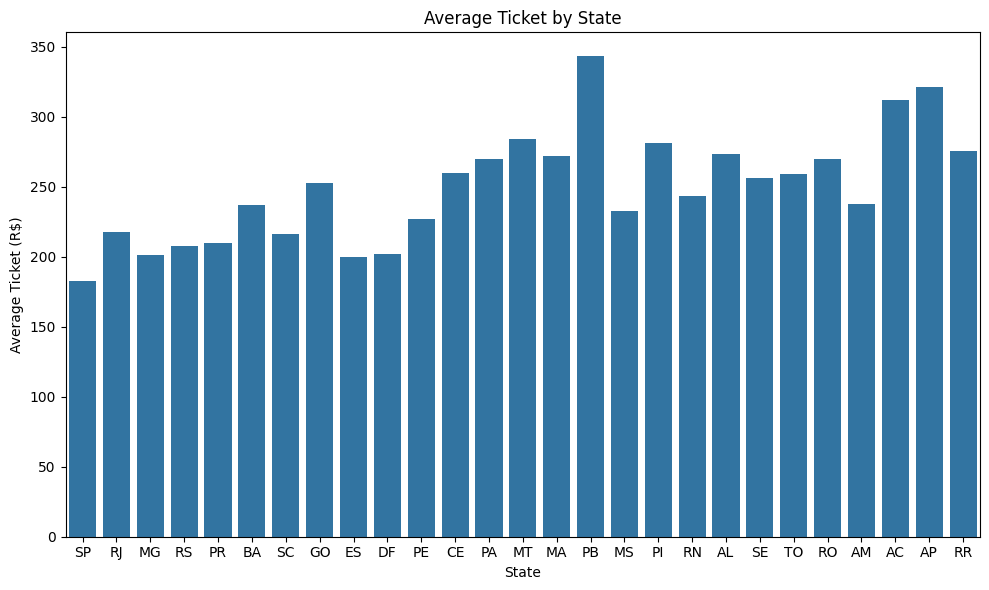

In [63]:
plt.figure(figsize=(10,6))
sns.barplot(x='state', y='avg_ticket', data=df_state_metrics)
plt.title('Average Ticket by State')
plt.xlabel('State')
plt.ylabel('Average Ticket (R$)')
plt.tight_layout()
plt.show()

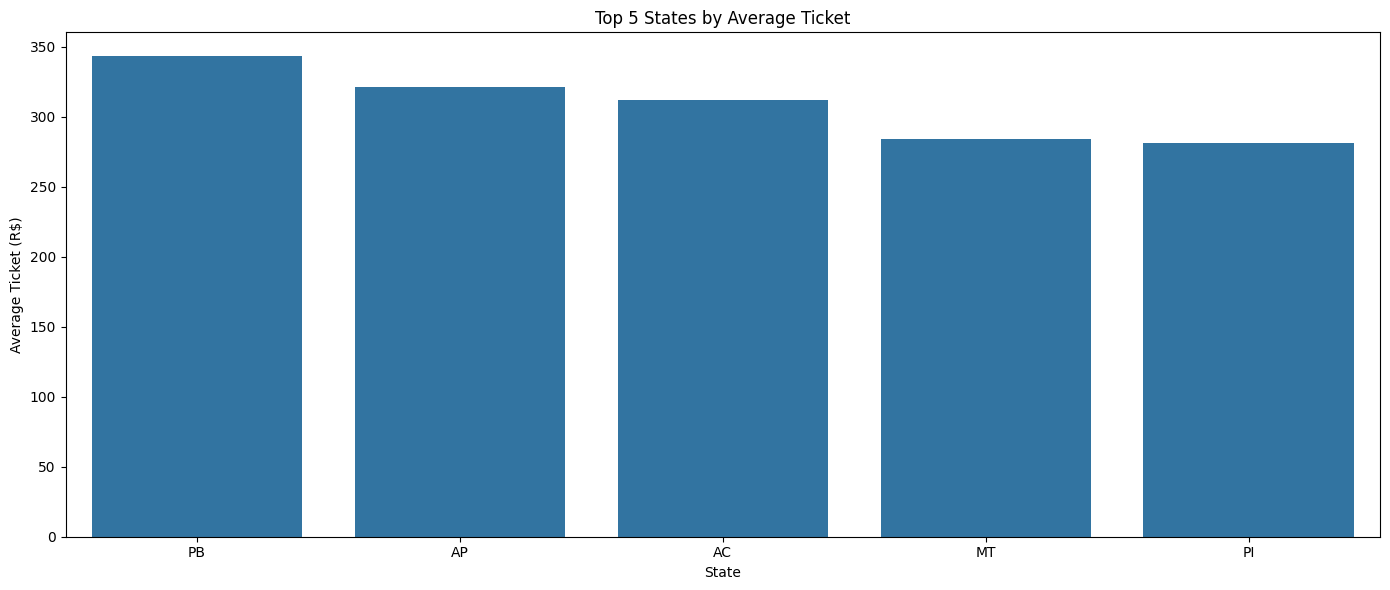

In [64]:

df_top_states = df_state_metrics.nlargest(5, 'avg_ticket')


plt.figure(figsize=(14,6))
sns.barplot(x='state', y='avg_ticket', data=df_top_states, order=df_top_states.sort_values('avg_ticket', ascending=False)['state'])
plt.title('Top 5 States by Average Ticket')
plt.xlabel('State')
plt.ylabel('Average Ticket (R$)')
plt.tight_layout()
plt.show()

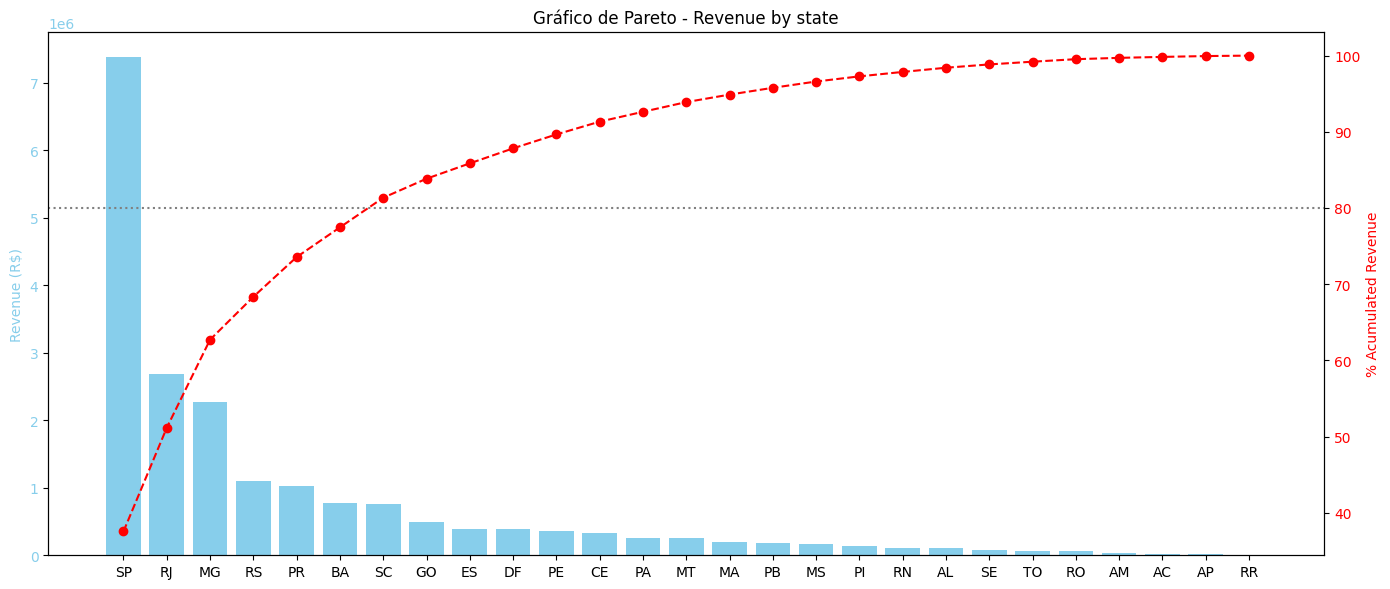

In [ ]:
# Calcular o acumulado
df_state_metrics['cumulative_revenue'] = df_state_metrics['total_revenue'].cumsum()
df_state_metrics['%_acumulated'] = (df_state_metrics['cumulative_revenue'] / total_revenue) * 100

# Plot
fig, ax1 = plt.subplots(figsize=(14,6))

# Barras
ax1.bar(df_state_metrics['state'], df_state_metrics['total_revenue'], color='skyblue')
ax1.set_ylabel('Revenue (R$)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Linha de Pareto
ax2 = ax1.twinx()
ax2.plot(df_state_metrics['state'], df_state_metrics['%_acumulated'], color='red', marker='o', linestyle='--')
ax2.set_ylabel('% Acumulated Revenue', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.axhline(80, color='gray', linestyle='dotted')  

plt.title('Gráfico de Pareto - Revenue by state')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df_state_metrics

Which Brazilian states have the highest average order value?

The states of PB, AC and AP have the highest average tickets per order, but these states don't even account for 2% of the company's total turnover. SP, on the other hand, even with a lower average ticket, accounts for around 37% of turnover, making it the most important state in terms of volume.

This indicates that, from a strategic point of view, it is more advantageous to invest in marketing, logistics or retention actions in the state of São Paulo, where the customer base is broader, even if the value per order is not the highest.
